In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import warnings
warnings.simplefilter('ignore', FutureWarning)

## In this notebook, I built a CNN model to classify three insects. The test accuracy of the final model looks great.

### load data

In [2]:
def read_directory(directory_name, remove_directory = None):
    ''' 
    Read all images in the directory. 
    And resize them using zero padding to make them in the same shape.
    Since some images appear in both the training set and the test set, I need to remove them from the training set.
    '''
    
    array_of_img = []
    for filename in os.listdir(r'./'+directory_name):
        if remove_directory is not None and filename in os.listdir(r'./'+remove_directory):
            continue
        img = cv2.imread(directory_name + '/' + filename)
        if img is not None:
            img = cv2.resize(img, dsize=(84, 84), interpolation=cv2.INTER_CUBIC)
            array_of_img.append(img)
    return array_of_img

def see_image(img):
    ''' For display convenience, change RGB to BGR.'''
    return(img[:,:,::-1])

In [3]:
## read data and resize to ()
categories = ['beetles', 'cockroach', 'dragonflies']
X_train = []
y_train = []
X_test = []
y_test = []

for category in categories:    
    xx = read_directory(r'insects/test/' + category)
    #xx = xx[:len(xx)-1]  ## the last one is 'None'
    yy = np.repeat(category, len(xx))
    X_test += list(xx)
    y_test += list(yy)
    
    x = read_directory(r'insects/train/' + category, r'insects/test/' + category)
    y = np.repeat(category, len(x))
    #print(len(y))
    X_train += list(x)
    y_train += list(y)

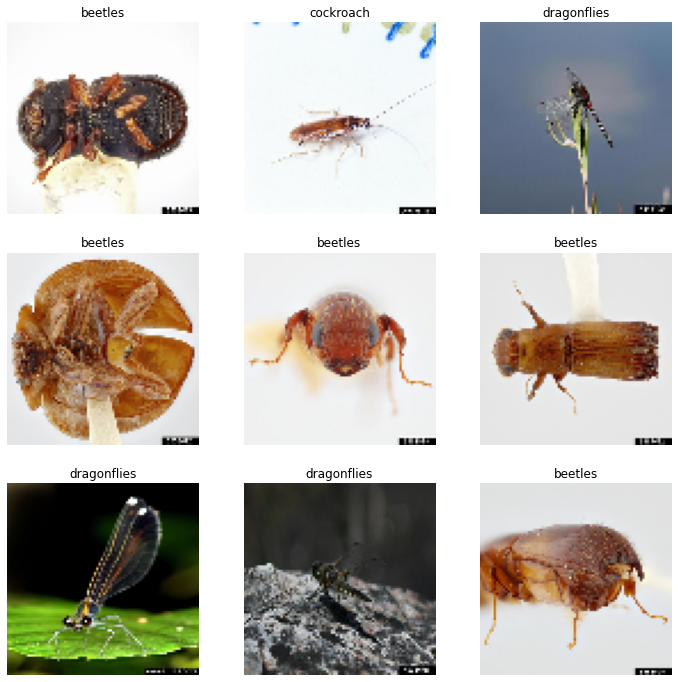

In [4]:
## show samples from the training set
f, axarr = plt.subplots(3,3, figsize = (12,12)) 
ids = np.random.randint(0, len(X_train), 9)

for i in range(len(ids)):
    axarr[i // 3, i % 3].imshow(see_image(X_train[ids[i]]))
    axarr[i // 3, i % 3].set_title(y_train[ids[i]])
    axarr[i // 3, i % 3].axis('off')
pass

Even the images have been resized, it does not seem to affect the classification.


### Data Preprocessing

In [5]:
batch_size = 32

In [6]:
## encode labels
le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

X_train_tensor = torch.Tensor(np.array(X_train) / 255) # transform to torch tensor
y_train_tensor = torch.Tensor(y_train).long()
X_test_tensor = torch.Tensor(np.array(X_test) / 255)
y_test_tensor = torch.Tensor(y_test).long()

train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor) # create datset
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

# create data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True) 
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

### CNN model

In [7]:
class CNN(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=3, stride=2, padding=1, bias=True)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, stride=1, padding=0, bias=True)
        self.fc1   = nn.Linear(in_features=64 * 9 * 9, out_features=256) 
        self.fc2   = nn.Linear(in_features=256, out_features=84)
        self.fc3   = nn.Linear(in_features=84, out_features=out_channels)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [8]:
def train(model, device, train_loader, criterion, optimizer, epoch):
    train_loss = 0
    correct = 0
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        data = Variable(data.reshape(-1, 3, 84, 84))
        #print(data.shape)
        target = Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        if batch_idx == len(train_loader)-1:
            print('Epoch {}, Training Loss: {:.4f}'.format(epoch, train_loss/(batch_idx+1)))
    acc = correct / len(train_loader.dataset)
    return(acc)
            
            
def test(model, device, test_loader, criterion, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data = Variable(data.reshape(-1, 3, 84, 84))
            target = Variable(target)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    acc = correct / len(test_loader.dataset)
    #test_loss = (test_loss*batch_size)/len(test_loader.dataset)
    print('Test{}: Accuracy: {:.4f}%'.format(epoch, 100. * acc))
    return(acc)

In [9]:
device = 'cuda'
device = torch.device(device)
num_epochs = 30
in_channels = 3
out_channels = 3
model = CNN(in_channels, out_channels).to(device)
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(),lr=0.01,momentum=0.9)
optimizer = optim.Adam(model.parameters(),lr=0.001)

train_acc = []
test_acc = []
for epoch in range(1, num_epochs + 1):
    train_acc.append(train(model, device, train_loader, criterion, optimizer, epoch))
    acc = test(model, device, test_loader, criterion, epoch)
    test_acc.append(acc)
    if epoch == 1 or old < acc:
        torch.save(model.state_dict(), 'ckpt_cnn.pth')
        old = acc

Epoch 1, Training Loss: 0.8212
Test1: Accuracy: 53.8889%
Epoch 2, Training Loss: 0.6749
Test2: Accuracy: 60.5556%
Epoch 3, Training Loss: 0.5401
Test3: Accuracy: 64.4444%
Epoch 4, Training Loss: 0.5047
Test4: Accuracy: 68.3333%
Epoch 5, Training Loss: 0.4964
Test5: Accuracy: 68.3333%
Epoch 6, Training Loss: 0.4239
Test6: Accuracy: 71.6667%
Epoch 7, Training Loss: 0.4125
Test7: Accuracy: 75.5556%
Epoch 8, Training Loss: 0.3473
Test8: Accuracy: 73.8889%
Epoch 9, Training Loss: 0.3287
Test9: Accuracy: 75.5556%
Epoch 10, Training Loss: 0.2837
Test10: Accuracy: 76.1111%
Epoch 11, Training Loss: 0.2651
Test11: Accuracy: 80.0000%
Epoch 12, Training Loss: 0.2219
Test12: Accuracy: 78.8889%
Epoch 13, Training Loss: 0.1908
Test13: Accuracy: 79.4444%
Epoch 14, Training Loss: 0.1459
Test14: Accuracy: 81.1111%
Epoch 15, Training Loss: 0.1165
Test15: Accuracy: 81.6667%
Epoch 16, Training Loss: 0.1056
Test16: Accuracy: 78.3333%
Epoch 17, Training Loss: 0.1380
Test17: Accuracy: 75.0000%
Epoch 18, Train

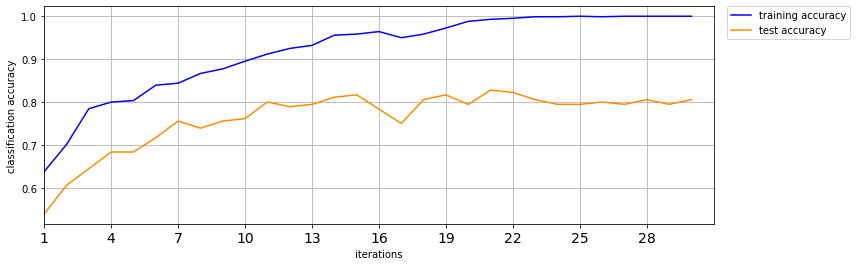

In [10]:
plt.figure(figsize=(12,4))
plt.plot(list(range(len(train_acc))), train_acc, color='blue', label='training accuracy')
plt.plot(list(range(len(test_acc))), test_acc, color='darkorange', label='test accuracy')
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)
plt.xlabel('iterations')
plt.ylabel('classification accuracy')
plt.grid()
plt.xlim(0, len(train_acc))
plt.xticks(list(range(0, len(train_acc), 3)),list(range(1, len(train_acc)+1, 3)), fontsize=14);
plt.show()

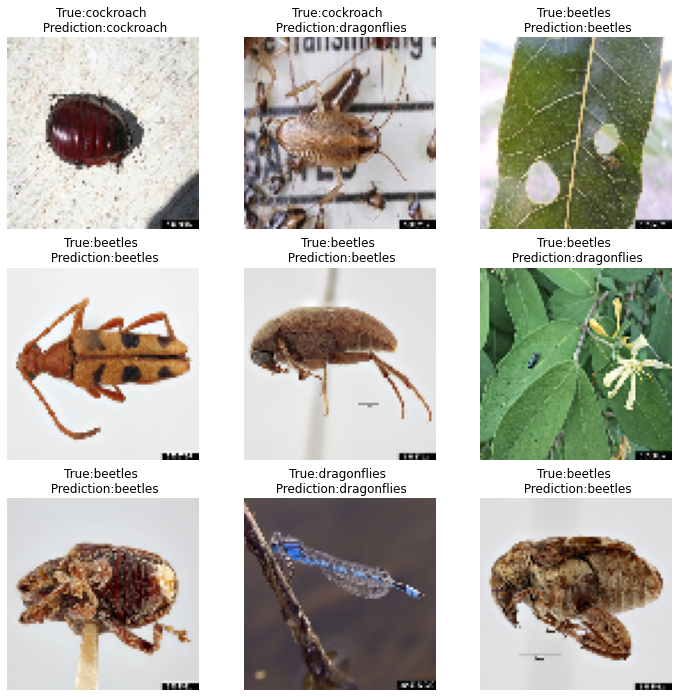

In [11]:
model = CNN(in_channels, out_channels).to(device)
model.load_state_dict(torch.load('ckpt_cnn.pth'))

## show samples from the test set
f, axarr = plt.subplots(3,3, figsize = (12,12)) 
data, label = next(iter(test_loader))
data = data[:9].to(device)
data = Variable(data.reshape(-1, 3, 84, 84))
output = model(data)
pred = output.argmax(dim=1, keepdim=True)
data = data.detach()
label = label.detach()
pred = pred.detach()
label = le.inverse_transform(label.cpu().numpy().ravel())
pred = le.inverse_transform(pred.cpu().numpy().ravel())

for i in range(9):
    axarr[i // 3, i % 3].imshow(see_image(data[i].cpu().numpy().reshape(84, 84, 3)))
    axarr[i // 3, i % 3].set_title(f'True:{label[i]} \n Prediction:{pred[i]}')
    axarr[i // 3, i % 3].axis('off')
pass